In [ ]:
# necessary for DenodoConnection
%pip install psycopg2-binary
%pip install shap
%pip install xgboost

In [2]:
# import packages
import os
import sys

import pandas as pd, numpy as np
import json
import argparse
import os

import pickle
import warnings

# need to add dme_sagemaker to path to load in libraries
sys.path.append("/root/dme_sagemaker/dme_sagemaker")

from libs.denodo.denodo_connection import DenodoConnection
import libs.performance_lib.performance_sql_recipes as performance_sql_recipes
from libs.helper.parameters_helper import ParametersHelper

from libs.performance_lib import predictive_advancement_lib
from libs.performance_lib import performance_validation_lib

import matplotlib.pyplot as plt
import boto3

from sklearn.model_selection import train_test_split

ENVIRONMENT name from config_vars: uat
DME_PROJECT name from config_vars: None


In [3]:
DKU_DST_ap_data_sector = 'CORN_LAS_SUMMER'
DKU_DST_analysis_type = 'GenoPred'
input_years = ['2020','2021','2022']
bucket = 'us.com.syngenta.ap.nonprod'

# convert each entry in input years to an integer since they come in as str.
if isinstance(input_years, list):
    input_years_as_int = [int(val) for val in input_years]
else:
    input_years_as_int = [int(input_years)]

In [4]:
# when testing, we read directly from S3, bucket is provided as a separate input to function, don't include in input args. 
input_args = [
    '--s3_input_pred_adv_data_folder', 'uat/dme/performance/compute_pred_adv_data_collected/data/'
]

parser = argparse.ArgumentParser(description='app inputs and outputs')
parser.add_argument('--s3_input_pred_adv_data_folder', type=str,
                    help='s3 input pred_adv_data folder', required=True)
args = parser.parse_args(input_args)

In [5]:
potential_fnames = predictive_advancement_lib.load_potential_fnames(prefix='new_')

df_input_piv = predictive_advancement_lib.load_and_preprocess_all_inputs_ml(
    args,
    DKU_DST_ap_data_sector,
    DKU_DST_analysis_type,
    potential_fnames,
    years_to_load=input_years,
    read_from_s3=1,
    bucket=bucket
)

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


(48057, 62)
(77164, 9)
(54014, 63)
(25373, 31)
(61901, 9)
(45591, 63)
(5407, 29)
(29, 4)
(42049, 9)


In [6]:
df_input_piv[df_input_piv['material_type_simple'] != 'entry'][['entry_identifier','current_stage','analysis_year']].groupby(by=['current_stage','analysis_year']).count()

entry_identifier
current_stage analysis_year                  
1.0           2020                      17447
              2021                      16939
              2022                      12382
2.0           2020                       1592
              2021                        766
              2022                       1221
3.0           2020                       1921
              2021                       2064
              2022                       1667
4.0           2020                        853
              2021                       3708
              2022                        253
5.0           2020                        226
              2021                       1570
              2022                       2596
6.0           2020                         43
              2021                        232
              2022                        272
7.0           2020                         27
              2021                        602
              2022                        267

In [7]:
for col in df_input_piv.columns:
    print(col, df_input_piv[col][(df_input_piv['current_stage'] == 4)].count())

ap_data_sector 10983
analysis_year 10983
entry_identifier 10983
material_type_simple 10983
chkfl_ERHTN 47
chkfl_ERTLP 57
chkfl_GMSTP 9664
chkfl_GRSNP 59
chkfl_GWTPN 9664
chkfl_HAVPN 9659
chkfl_LRTLP 47
chkfl_LRTLR 9617
chkfl_PLHTN 59
chkfl_PLTAR 4088
chkfl_PLTQR 10983
chkfl_STD_N 9674
chkfl_STD_P 9661
chkfl_STKLP 48
chkfl_STKLR 9617
chkfl_TWSMN 9614
chkfl_YGHMN 9662
chkfl_YGMRN 9662
chkfl_YGSMN 9664
cpifl 10928
result_ERHTN 47
result_ERTLP 57
result_GMSTP 9664
result_GRSNP 59
result_GWTPN 9664
result_HAVPN 9659
result_LRTLP 47
result_LRTLR 9617
result_PLHTN 59
result_PLTAR 4088
result_PLTQR 10983
result_STD_N 9674
result_STD_P 9661
result_STKLP 48
result_STKLR 9617
result_TWSMN 9614
result_YGHMN 9662
result_YGMRN 9662
result_YGSMN 9664
result_diff_ERHTN 47
result_diff_ERTLP 57
result_diff_GMSTP 9664
result_diff_GRSNP 59
result_diff_GWTPN 9664
result_diff_HAVPN 9659
result_diff_LRTLP 47
result_diff_LRTLR 9617
result_diff_PLHTN 59
result_diff_PLTAR 4088
result_diff_PLTQR 10983
result_dif

In [8]:
df_input_piv[['was_adv','current_stage','analysis_year']].groupby(by=['current_stage','analysis_year']).sum()

was_adv
current_stage analysis_year         
1.0           2020            2423.0
              2021             513.0
              2022             247.0
2.0           2020             296.0
              2021              81.0
              2022             113.0
3.0           2020             561.0
              2021             776.0
              2022             518.0
4.0           2020             182.0
              2021            1726.0
              2022              35.0
5.0           2020              45.0
              2021             348.0
              2022             320.0
6.0           2020               0.0
              2021               0.0
              2022               0.0
7.0           2020               0.0
              2021               0.0
              2022               0.0

In [11]:
traits = ['GMSTP','HAVPN','LRTLR','PLTQR','STD_N','STD_P','STKLR','TWSMN','YGSMN']

df_piv = df_input_piv[(df_input_piv['material_type_simple'] != 'entry') &
                      (df_input_piv['current_stage'] >= 2) &
                      (df_input_piv['current_stage'] <= 4)] 

df_piv[['was_adv'] + ['result_'+trait for trait in traits]].corr()

,was_adv,result_GMSTP,result_HAVPN,result_LRTLR,result_PLTQR,result_STD_N,result_STD_P,result_STKLR,result_TWSMN,result_YGSMN
was_adv,1.000000,-0.012768,-0.004156,-0.024426,0.013390,-0.058275,-0.133845,-0.154787,0.027432,0.174726
result_GMSTP,-0.012768,1.000000,0.166947,-0.220556,0.139580,-0.274002,0.183996,-0.071037,0.275852,-0.244815
result_HAVPN,-0.004156,0.166947,1.000000,0.226749,0.068661,-0.011256,-0.023048,0.352211,0.178663,-0.090633
result_LRTLR,-0.024426,-0.220556,0.226749,1.000000,-0.117775,0.231689,0.085549,0.169274,0.110276,0.285563
result_PLTQR,0.013390,0.139580,0.068661,-0.117775,1.000000,-0.297635,-0.004068,-0.117602,-0.172890,-0.328704
result_STD_N,-0.058275,-0.274002,-0.011256,0.231689,-0.297635,1.000000,-0.004393,0.351076,0.188652,0.422070
result_STD_P,-0.133845,0.183996,-0.023048,0.085549,-0.004068,-0.004393,1.000000,0.289723,-0.014701,0.001168
result_STKLR,-0.154787,-0.071037,0.352211,0.169274,-0.117602,0.351076,0.289723,1.000000,0.111350,0.110550
result_TWSMN,0.027432,0.275852,0.178663,0.110276,-0.172890,0.188652,-0.014701,0.111350,1.000000,0.332821
result_YGSMN,0.174726,-0.244815,-0.090633,0.285563,-0.328704,0.422070,0.001168,0.110550,0.332821,1.000000


In [12]:
traits = ['GMSTP','HAVPN','LRTLR','PLTQR','STD_N','STD_P','STKLR','TWSMN','YGSMN']

df_piv = df_input_piv[(df_input_piv['material_type_simple'] != 'entry') &
                      (df_input_piv['current_stage'] >= 2) &
                      (df_input_piv['current_stage'] <= 4)] 

df_piv[['was_adv'] + ['result_diff_'+trait for trait in traits]].corr()

,was_adv,result_diff_GMSTP,result_diff_HAVPN,result_diff_LRTLR,result_diff_PLTQR,result_diff_STD_N,result_diff_STD_P,result_diff_STKLR,result_diff_TWSMN,result_diff_YGSMN
was_adv,1.000000,0.034699,0.011938,-0.074531,-0.006719,-0.001416,0.009687,-0.096250,0.000161,0.324925
result_diff_GMSTP,0.034699,1.000000,0.054563,0.011088,0.017405,0.000920,-0.005280,-0.165248,0.426622,0.129949
result_diff_HAVPN,0.011938,0.054563,1.000000,0.028877,-0.022408,0.274497,0.227842,0.014765,-0.036264,0.016885
result_diff_LRTLR,-0.074531,0.011088,0.028877,1.000000,0.025659,0.036122,0.040566,0.244714,-0.071200,-0.042090
result_diff_PLTQR,-0.006719,0.017405,-0.022408,0.025659,1.000000,0.149392,0.141889,-0.002589,-0.020400,-0.042861
result_diff_STD_N,-0.001416,0.000920,0.274497,0.036122,0.149392,1.000000,0.975909,0.013579,-0.026069,0.054098
result_diff_STD_P,0.009687,-0.005280,0.227842,0.040566,0.141889,0.975909,1.000000,0.020448,-0.034165,0.063665
result_diff_STKLR,-0.096250,-0.165248,0.014765,0.244714,-0.002589,0.013579,0.020448,1.000000,-0.097553,-0.184364
result_diff_TWSMN,0.000161,0.426622,-0.036264,-0.071200,-0.020400,-0.026069,-0.034165,-0.097553,1.000000,0.015115
result_diff_YGSMN,0.324925,0.129949,0.016885,-0.042090,-0.042861,0.054098,0.063665,-0.184364,0.015115,1.000000


In [13]:
#### FILTER TO DESIRED DATA for training
# filter materials: want stages 1-4, material type is parent for corn
# want stages 2-5, material type is entry for soy
df_input_piv['current_stage_grouped'] = 1
df_input_piv['current_stage_grouped'][(df_input_piv['current_stage']>1) & (df_input_piv['current_stage']<=4)] = 2

df_piv = df_input_piv[(df_input_piv['material_type_simple'] != 'entry') &
                      (df_input_piv['current_stage'] >= 2) &
                      (df_input_piv['current_stage'] <= 4)]

#### preprocess text traits for corn
if 'decision_group' not in df_piv.columns:
    df_piv['decision_group'] = df_piv['current_stage']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
### train model.
grouping_cols = predictive_advancement_lib.get_grouping_cols_per_sector(analysis_sector=DKU_DST_ap_data_sector)
#grouping_cols.remove('current_stage')
#grouping_cols.append('current_stage_grouped')
df_piv_grouped = df_piv.groupby(by=grouping_cols)

In [15]:
def stratified_train_test_split(df_in, out_col):
    df_tr_list = []
    df_te_list = []
    
    for out_val in pd.unique(df_in[out_col]):
        df_in_val = df_in[df_in[out_col] == out_val]
        df_tr_val, df_te_val = train_test_split(df_in_val, test_size=0.2)
        df_tr_list.append(df_tr_val)
        df_te_list.append(df_te_val)
        
    df_tr = pd.concat(df_tr_list,axis=0)
    df_te = pd.concat(df_te_list,axis=0)
    
    return df_tr, df_te


In [19]:
for index, df_use in df_piv_grouped:  # build model per unique combination of grouping_cols; stage currently
    # get model parameters for this sector and stage
    args = []
    # model parameters
    # extract inputs from args
    # get input and output column names
    
    if index[1] == 1:
        extra_traits = []
        numeric_diff_traits = ['YGSMN'] #'YGSMN-PLHTN-ERHTN-GMSTP', plhtn and erhtn are sparse
        numeric_raw_traits = ['GMSTP','TWSMN','LRTLR','PLTQR','STD_P','STKLR']
        text_traits = [] #'pltqt','notet' at some point?
        prediction_traits = []
        
        preproc_steps = []
        
    elif index[1] == 2:
        extra_traits = ['current_stage']
        numeric_diff_traits = ['YGSMN'] #'YGSMN-PLHTN-ERHTN-GMSTP', plhtn and erhtn are sparse
        numeric_raw_traits = ['GMSTP','TWSMN','LRTLR','PLTQR','STD_P','STKLR']
        prediction_traits = []
        text_traits = [] #'pltqt','notet' at some point?
        
        preproc_steps = []
        
    elif index[1] == 3:
        extra_traits = []
        numeric_diff_traits = ['YGSMN'] #'YGSMN-PLHTN-ERHTN-GMSTP', plhtn and erhtn are sparse
        numeric_raw_traits = ['GMSTP','TWSMN','LRTLR','PLTQR','STD_P','STKLR']
        prediction_traits = []
        text_traits = [] #'pltqt','notet' at some point?
        
        preproc_steps = []
        
    elif index[1] == 4:
        extra_traits = []
        numeric_diff_traits = ['YGSMN'] #'YGSMN-PLHTN-ERHTN-GMSTP', plhtn and erhtn are sparse
        numeric_raw_traits = ['GMSTP','TWSMN','LRTLR','PLTQR','STD_P','STKLR']
        prediction_traits = []
        text_traits = [] #'pltqt','notet' at some point?
        
        preproc_steps = []
        
    mdl_in_cols = extra_traits
    mdl_in_cols.extend(['result_diff_' + trait for trait in numeric_diff_traits])
    mdl_in_cols.extend(['result_' + trait for trait in numeric_raw_traits])
    mdl_in_cols.extend([trait+'_prediction' for trait in prediction_traits])

    cols_to_norm = []
    mdl_out_col = 'was_adv'

    # get parameters for xgboost models
    xgb_params_class = predictive_advancement_lib.XGBoostModelParameters(
        max_depth=5,
        reg_lambda=100,
        subsample=0.2,
        learning_rate=0.005,
        n_estimators=500
    )

    # if the output var is not a boolean, this causes problems. check
    if not isinstance(df_use[mdl_out_col].dtype, bool):
        df_use[mdl_out_col] = df_use[mdl_out_col].astype(bool)

    preproc_class = predictive_advancement_lib.PredAdvPreprocessor(
        preprocess_steps=preproc_steps,
        corr_traits=[
            [['PLHTN','ERHTN','GMSTP'],['YGSMN']]
        ],
        corr_score_col='result_diff'
        
    )    

    mdl_class = predictive_advancement_lib.PredAdvMdl(
        params=xgb_params_class.params,
        in_cols=mdl_in_cols,
        out_col=mdl_out_col,
        weight_by_col=False
    )
  
    df_tr, df_te = stratified_train_test_split(df_use, out_col='was_adv')
    df_tr_proc = preproc_class.train_preprocessing(df_tr)
    
    # update mdl in cols based on preprocessing steps
    if 'process rm' in preproc_class.preprocess_steps:
        mdl_class.in_cols.append('rm_estimate_proc')
        # if there are dummy vars added to df_use_proc due to processing text traits, add to mdl in cols
    if 'process text traits' in preproc_class.preprocess_steps:
        new_cols = list(set(df_tr_proc.columns).difference(set(df_use.columns)))
        if 'process rm' in preproc_class.preprocess_steps:
            mdl_class.in_cols.remove('rm_estimate_proc')
        mdl_class.in_cols.extend(new_cols)
    if 'get qualifiers' in preproc_class.preprocess_steps:
        cols_to_append = df_tr_proc.columns[['qualifiers_' in col for col in df_tr_proc.columns]]
        mdl_in_cols.extend(cols_to_append)

        
    # make sure each column in mdl_in col is also in the dataframe
    mdl_in_cols_use = mdl_in_cols.copy()
    for col in mdl_in_cols:
        if col not in df_use.columns:
            mdl_in_cols_use.remove(col)
    mdl_in_cols = mdl_in_cols_use
        
    mdl_class.train_mdl(df_tr_proc);
    df_tr_proc['recommendation_score'] = mdl_class.predict_proba(df_tr_proc)
    df_input_stats = performance_validation_lib.compute_input_statistics(
        df_in=df_tr_proc,
        in_cols=mdl_class.in_cols
    )
    # get predictions, print metrics on training dataset (not representative of performance).
    print("Train:",index,df_tr_proc.shape,mdl_class.score(df_tr_proc, df_tr_proc[mdl_out_col].values))
    
    # some validation metrics:    
    df_te_proc = preproc_class.train_preprocessing(df_te)
    print("Test",index,df_te_proc.shape,mdl_class.score(df_te_proc, df_te_proc[mdl_out_col].values))

Train: ('CORN_LAS_SUMMER', 2) (11235, 98) (0.7707728710748556, array([[0.75629984, 0.24370016],
       [0.2147541 , 0.7852459 ]]), 0.8556260040729412, 0.5169994603345925)
Test ('CORN_LAS_SUMMER', 2) (2810, 97) (0.7543036865401183, array([[0.74659864, 0.25340136],
       [0.23799127, 0.76200873]]), 0.8386832353028549, 0.49750534568781185)


Exact explainer: 1001it [01:43,  9.67it/s]                         


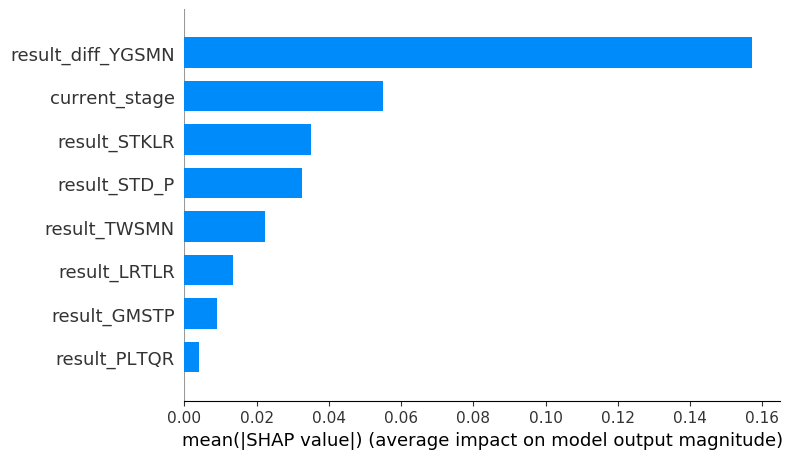

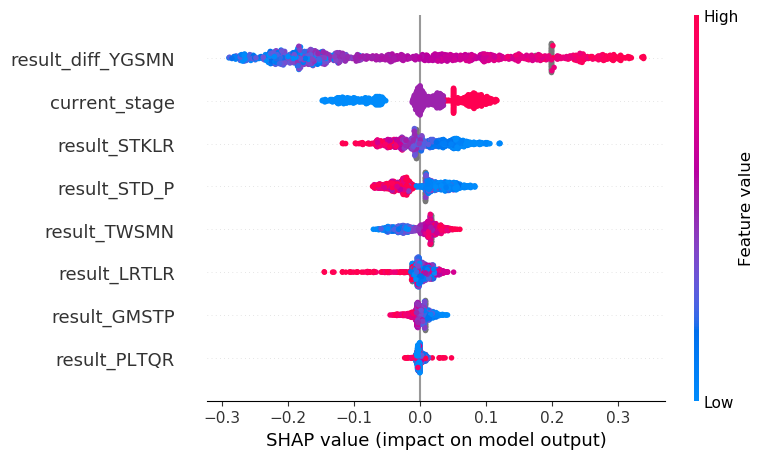

In [21]:
#shap code for new class method
# get and plot shapley values after training a model
do_shap = 1
if do_shap == 1:
    import shap
    x = df_te_proc[mdl_class.in_cols].values.astype(float)
    shap_input = shap.utils.sample(x, np.minimum(x.shape[0],1000))
    explainer = shap.Explainer(mdl_class.mdl.predict_proba, shap_input)
    shap_values = explainer(shap_input)
    shap_values = shap_values[:,:,1]

    shap.summary_plot(shap_values, feature_names=mdl_class.in_cols,\
                     plot_type='bar')

    shap.summary_plot(shap_values, feature_names=mdl_class.in_cols,\
                     plot_type='dot')

#for idx in range(len(mdl_class.in_cols)):
#    notnan_mask = np.isnan(shap_input[:,idx])==False
#    if np.sum(notnan_mask) > 10:
#        shap.plots.partial_dependence(idx,mdl_class.mdl.predict,shap_input[notnan_mask,:],ice=False,feature_names=mdl_class.in_cols)

# some useful shapley/interpolation related code
#plt.plot(shap_values[:,0].data, shap_values[:,0].values,'.')
#shap.plots.scatter(shap_values[:,5])

In [27]:
# make sure advancement columns are boolean
df_input = df_te_proc.copy()
df_input['recommendation_score'] = mdl_class.predict_proba(df_input)
if 'was_adv' in df_input.columns:
    df_input['was_adv'] = df_input['was_adv'].astype(bool)
if 'was_adv_next' in df_input.columns:
    df_input['was_adv_next'] = df_input['was_adv_next'].astype(bool)

# set trait column and yield column based on data sector
trait_prefix = 'result_' # this gets both result_ and result_diff cols
yield_col = 'result_diff_YGSMN' #'result_diff_YGSMN-PLHTN-ERHTN-GMSTP'

# compute metrics for each stage
adv_metrics_all = []
trait_metrics_all = []

for stg in pd.unique(df_input['current_stage_grouped']):
    df_use = df_input[df_input['current_stage_grouped'] == stg]
    df_use['random_nums'] = np.random.rand(df_use.shape[0], 1)
    adv_metrics, trait_metrics = performance_validation_lib.compute_model_metrics(
        df_use,
        compute_advancement_metrics=True,
        yield_col=yield_col,
        trait_prefix=trait_prefix
    )
    adv_metrics['stage'] = stg
    trait_metrics['stage'] = stg

    adv_metrics_all.append(adv_metrics)
    trait_metrics_all.append(trait_metrics)

# join across stages
df_adv_metrics = pd.concat(adv_metrics_all,axis=0)
df_trait_metrics = pd.concat(trait_metrics_all,axis=0)

invalid value encountered in true_divide
invalid value encountered in long_scalars
All-NaN slice encountered
Mean of empty slice
Mean of empty slice
Degrees of freedom <= 0 for slice.


In [28]:
np.sum(df_te_proc['was_adv'])/df_te_proc.shape[0]

0.16298932384341638

In [30]:
df_adv_metrics[(df_adv_metrics['decision_group'] == 'all')]

,mdl,decision_group,metric,value,stage
1200,ML,all,AUC_PR_adv,0.513731,2
1201,ML,all,AUC_PR_notadv,0.961829,2
1202,ML,all,TN,2124.000000,2
1203,ML,all,FP,228.000000,2
1204,ML,all,FN,228.000000,2
1205,ML,all,TP,230.000000,2
1206,ML,all,n,2810.000000,2
1207,ML,all,perc_adv_in_bottom_75perc,0.336245,2
1208,yield,all,AUC_PR_adv,0.346849,2
1209,yield,all,AUC_PR_notadv,0.926258,2
